In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import wfdb
import pandas as pd
import ast
import random
import seaborn as sns


import torch
import torch.nn as nn
import torch.optim as optim

# Configurable variables

In [4]:
# data vars
path = 'physionet.org/files/ptb-xl/1.0.3/'
sampling_rate=100

# test train split using existing ptbxl folds
test_fold = 10
val_fold = 9

# Data Loading

In [54]:
# function to load data with wfdb
def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(path+f) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data

# load and convert annotation data
DF = pd.read_csv(path+'ptbxl_database.csv', index_col='ecg_id')
DF.scp_codes = DF.scp_codes.apply(lambda x: ast.literal_eval(x))

# Load raw signal data
print('Loading data...')
X = load_raw_data(DF, sampling_rate, path)
print('Data loaded.')

# Load scp_statements.csv for diagnostic aggregation
print('Loading scp_statements...')
agg_df = pd.read_csv(path+'scp_statements.csv', index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]
print('Scp statements loaded.')

def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

# Apply diagnostic superclass
DF['diagnostic_superclass'] = DF.scp_codes.apply(aggregate_diagnostic)

#superclasses = np.unique([elem for sublist in DF.diagnostic_superclass for elem in sublist])


# Convert superclasses to binary matrix
Z = pd.DataFrame(0, index=DF.index, columns=['NORM', 'MI', 'STTC', 'CD', 'HYP'], dtype='int')
for i in Z.index:
    for k in DF.loc[i].diagnostic_superclass:
        Z.loc[i, k] = 1

Loading data...
Data loaded.
Loading scp_statements...
Scp statements loaded.


# Create Test/Train/Validation Split

In [55]:
X_train = X[np.where(DF.strat_fold <= 8)]
y_train = Z[(DF.strat_fold <= 8)]
y_train_text = DF[(DF.strat_fold <= 8)].diagnostic_superclass

X_val = X[np.where(DF.strat_fold == val_fold)]
y_val = Z[DF.strat_fold == val_fold]

X_test = X[np.where(DF.strat_fold == test_fold)]
y_test = Z[DF.strat_fold == test_fold]

# Data Normalisation

In [56]:
from sklearn.preprocessing import StandardScaler

# Normalise data
X_scaler = StandardScaler()
X_scaler.fit(X_train.reshape(-1, X_train.shape[-1]))

X_train = X_scaler.transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_val = X_scaler.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)
X_test  = X_scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

# Save data in NumPy format

In [58]:
NP_DATA = f'data/PTB_XL_{sampling_rate}hz.npz'

save_args = {
    'X_train': X_train.astype(np.float32),
    'X_val': X_val.astype(np.float32),
    'X_test': X_test.astype(np.float32),
    'y_train': y_train.values.astype(np.float32),
    'y_train_text': y_train_text,
    'y_val': y_val.values.astype(np.float32),
    'y_test': y_test.values.astype(np.float32),
}

np.savez(NP_DATA, **save_args)

# Load and Visualise Data

In [59]:
thismodule = sys.modules[__name__]

with np.load(NP_DATA, allow_pickle=True) as data:
    for k in data.keys():
        if k == 'y_train_text':
            setattr(thismodule, k, data[k])
        else:
            setattr(thismodule, k, data[k].astype(float))

Train data shape:  (17418, 1000, 12) Train labels shape:  (17418, 5) Train labels text shape:  (17418,)
Val data shape:  (2183, 1000, 12) Val labels shape:  (2183, 5)
Test data shape:  (2198, 1000, 12) Test labels shape:  (2198, 5)
Random sample:  5855
['NORM', 'MI', 'STTC', 'CD', 'HYP']
Labels:  [0. 0. 0. 1. 0.]
Labels:  ['CD']


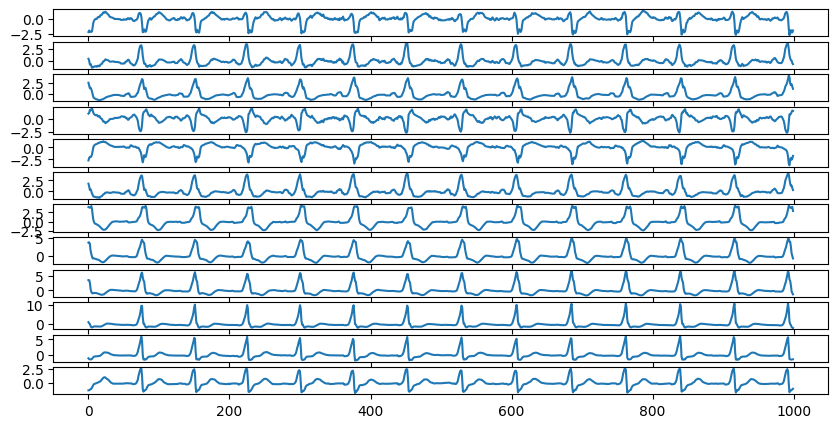

In [60]:
print('Train data shape: ', X_train.shape, 'Train labels shape: ', y_train.shape, 'Train labels text shape: ', y_train_text.shape)
print('Val data shape: ', X_val.shape, 'Val labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape, 'Test labels shape: ', y_test.shape)

rand_sample_i = random.randint(0, X_train.shape[0])
print('Random sample: ', rand_sample_i)
rand_sample = X_train[rand_sample_i]

bar, axes = plt.subplots(rand_sample.shape[1], 1, figsize=(10,5))
for i in range(rand_sample.shape[1]):
    sns.lineplot(x=np.arange(rand_sample.shape[0]), y=rand_sample[:, i], ax=axes[i])

print(['NORM', 'MI', 'STTC', 'CD', 'HYP'])
print('Labels: ', y_train[rand_sample_i])
print('Labels: ', y_train_text[rand_sample_i])

# Extracting Beats from the data

(1000, 12)
(1000,)
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
[ 66  87 148 223 298 373 450 527 604 682 760 837 913 989]
Number of heartbeats:  13


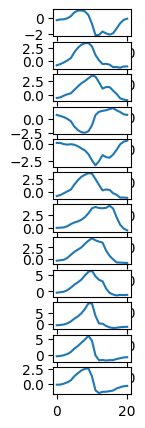

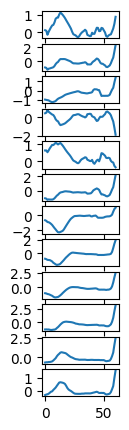

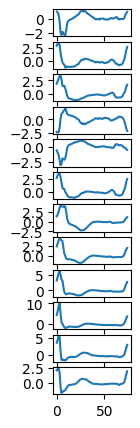

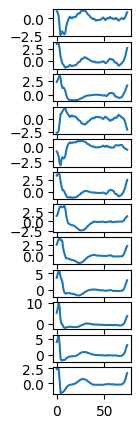

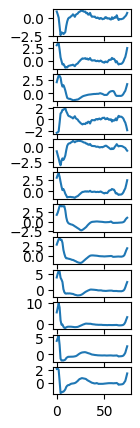

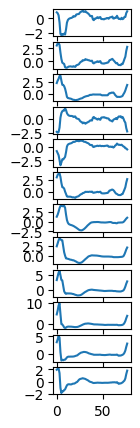

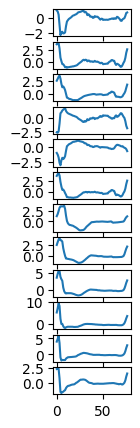

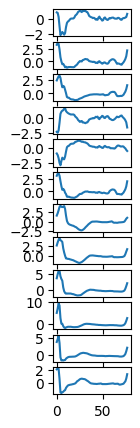

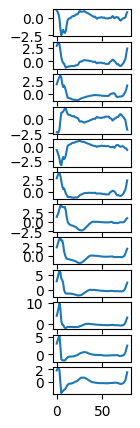

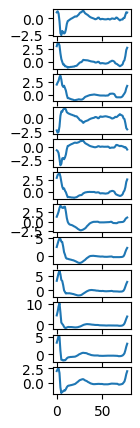

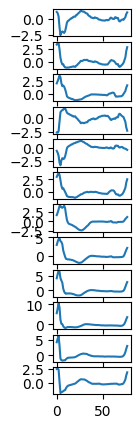

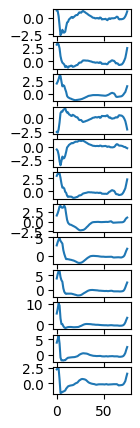

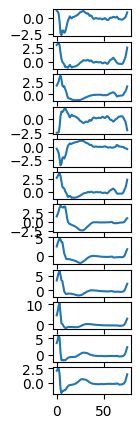

In [61]:
from wfdb import processing

# sig, fields = wfdb.rdsamp(path+DF.iloc[rand_sample_i].filename_lr, channels=[0])

rand_sample = X_train[rand_sample_i]
print(rand_sample.shape)
print(rand_sample[:,0].shape)

xqrs = processing.XQRS(sig=rand_sample[:,0], fs=sampling_rate)
xqrs.detect()

# wfdb.plot_items(signal=rand_sample[:,0], ann_samp=[xqrs.qrs_inds])

print(xqrs.qrs_inds)

# split sample in individual heartbeats

# get qrs indices
qrs_inds = xqrs.qrs_inds

# get heartbeats
heartbeats = []

for i in range(len(qrs_inds)-1):
    heartbeats.append(rand_sample[qrs_inds[i]:qrs_inds[i+1]])
    
print('Number of heartbeats: ', len(heartbeats))

# plot heartbeats
for hb in heartbeats:
    bar, axes = plt.subplots(hb.shape[1], 1, figsize=(1,5))
    for i in range(hb.shape[1]):
        sns.lineplot(x=np.arange(hb.shape[0]), y=hb[:, i], ax=axes[i])
    


In [62]:
# create a new dataframe with individual heartbeats
# X is DF of 10s ECGs
# Z is DF of diagnostic superclasses

# X_HB is DF of individual heartbeats
# Z_HB is DF of diagnostic superclasses for individual heartbeats

# initialise new arrays
X_HB = []
Z_HB = []
Z_HB_text = []
Samp_og_HB = []
Strat_og_HB = []

window_size = sampling_rate 

# iterate over each 10s ECG
for i, sample in enumerate(X):
    print("Progress:", i, "/", X.shape[0], end="\r")
    xqrs = processing.XQRS(sig=sample[:,0], fs=sampling_rate)
    xqrs.detect(verbose=False)
    qrs_inds = xqrs.qrs_inds
    for indx in qrs_inds:
        if indx + window_size > sample.shape[0] or indx - window_size < 0:
            continue
        X_HB.append(sample[indx-window_size:indx+window_size])
        Z_HB.append(Z.iloc[i])
        Z_HB_text.append(DF.iloc[i].diagnostic_superclass)
        Samp_og_HB.append(i)
        Strat_og_HB.append(DF.iloc[i].strat_fold)
    
X_HB = np.array(X_HB)
Z_HB = np.array(Z_HB)
    
print(X_HB.shape)
print(Z_HB.shape)
        


(256201, 200, 12) 21799
(256201, 5)


In [63]:
# save the new data
np.savez('data/PTB_XL_HB_2s_window.npz', X_HB=X_HB, Z_HB=Z_HB, Z_HB_text=Z_HB_text, Samp_og_HB=Samp_og_HB, Strat_og_HB=Strat_og_HB)

/home/raaif/anaconda3/envs/FYP/lib/python3.9/site-packages/numpy/lib/npyio.py:719: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


In [5]:
# load data
thismodule = sys.modules[__name__]

with np.load('data/PTB_XL_HB_2s_window.npz', allow_pickle=True) as data:
    for k in data.keys():
        if k == 'Z_HB_text':
            setattr(thismodule, k, data[k])
        else:
            setattr(thismodule, k, data[k].astype(float))

Heartbeat data shape:  (256201, 200, 12) Heartbeat labels shape:  (256201, 5) Heartbeat labels text shape:  (256201,)
Classes: ['NORM', 'MI', 'STTC', 'CD', 'HYP']
Labels:  [0. 1. 0. 0. 0.]
Labels:  ['MI']


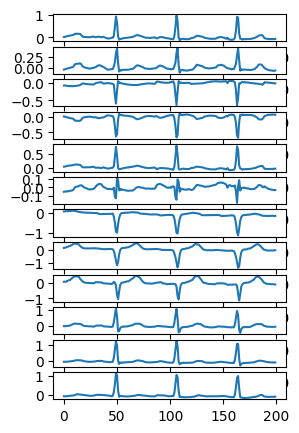

In [11]:
print('Heartbeat data shape: ', X_HB.shape, 'Heartbeat labels shape: ', Z_HB.shape, 'Heartbeat labels text shape: ', Z_HB_text.shape)

# get random sample
rand_sample_i = random.randint(0, X_HB.shape[0])
rand_sample = X_HB[rand_sample_i]
rand_sample_label = Z_HB[rand_sample_i]
rand_sample_label_text = Z_HB_text[rand_sample_i]

bar, axes = plt.subplots(rand_sample.shape[1], 1, figsize=(3,5))
for i in range(rand_sample.shape[1]):
    sns.lineplot(x=np.arange(rand_sample.shape[0]), y=rand_sample[:, i], ax=axes[i])
    
print("Classes:",['NORM', 'MI', 'STTC', 'CD', 'HYP'])
print('Labels: ', rand_sample_label)
print('Labels: ', rand_sample_label_text)

In [14]:
X_train = X_HB[np.where(Strat_og_HB <= 8)]
y_train = Z_HB[(Strat_og_HB <= 8)]
y_train_text =Z_HB_text[(Strat_og_HB <= 8)]

X_val = X_HB[np.where(Strat_og_HB == val_fold)]
y_val = Z_HB[Strat_og_HB == val_fold]

X_test = X_HB[np.where(Strat_og_HB == test_fold)]
y_test = Z_HB[Strat_og_HB == test_fold]

print('Train data shape: ', X_train.shape, 'Train labels shape: ', y_train.shape, 'Train labels text shape: ', y_train_text.shape)

Train data shape:  (204158, 200, 12) Train labels shape:  (204158, 5) Train labels text shape:  (204158,)


Random heartbeat:  121397
Labels:  [1. 0. 0. 0. 0.]


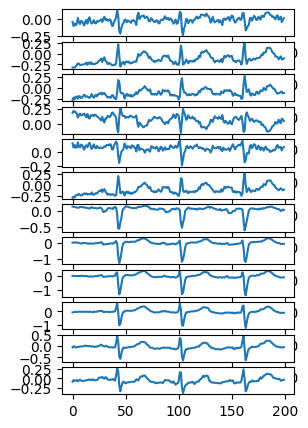

In [23]:
random_heartbeat_index = random.randint(0, X_HB.shape[0])
print('Random heartbeat: ', random_heartbeat_index)
random_beat = X_HB[random_heartbeat_index]
random_beat_labels = Z_HB[random_heartbeat_index]

# plot random heartbeat
bar, axes = plt.subplots(random_beat.shape[1], 1, figsize=(3,5))
for i in range(random_beat.shape[1]):
    sns.lineplot(x=np.arange(random_beat.shape[0]), y=random_beat[:, i], ax=axes[i])


print('Labels: ', random_beat_labels)

In [69]:
# define cnn model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import metrics

# model for windowed data

def cnn_model(X, num_classes=5, filters = [16, 32, 64], kernels = [5,3,3]):
    
    X = keras.layers.Conv1D(filters=filters[0], kernel_size=kernels[0], input_shape=X.shape[1:])(X)
    X = keras.layers.BatchNormalization()(X)
    X = keras.layers.Activation('relu')(X)
    
    X = keras.layers.MaxPooling1D(2)(X)
    
    X = keras.layers.Conv1D(filters=filters[1], kernel_size=kernels[1])(X)
    X = keras.layers.BatchNormalization()(X)
    X = keras.layers.Activation('relu')(X)
    
    X = keras.layers.MaxPooling1D(2)(X)
    
    X = keras.layers.Conv1D(filters=filters[2], kernel_size=kernels[2])(X)
    X = keras.layers.BatchNormalization()(X)
    X = keras.layers.Activation('relu')(X)
    
    features_output = keras.layers.GlobalAveragePooling1D()(X)
    X = keras.layers.Dropout(0.5)(features_output)
    
    X = keras.layers.Dense(128, activation='relu')(X)
    X = keras.layers.Dense(num_classes, activation='sigmoid')(X)
    
    
    return X, features_output

num_classes = 5
X_input = keras.Input(shape=X_train.shape[1:])
outputs, feature_output = cnn_model(X_input, num_classes=num_classes)

model = keras.Model(inputs=X_input, outputs=outputs)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall', metrics.binary_accuracy])
model.summary()


Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 200, 12)]         0         
                                                                 
 conv1d_117 (Conv1D)         (None, 196, 16)           976       
                                                                 
 batch_normalization_117 (Ba  (None, 196, 16)          64        
 tchNormalization)                                               
                                                                 
 activation_116 (Activation)  (None, 196, 16)          0         
                                                                 
 max_pooling1d_29 (MaxPoolin  (None, 98, 16)           0         
 g1D)                                                            
                                                                 
 conv1d_118 (Conv1D)         (None, 96, 32)            156

In [77]:
# define a resnet model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import metrics

def resnet_block(X, filters, kernel_size=3):
        
        X_shortcut = X
        
        X = keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, padding='same')(X)
        X = keras.layers.BatchNormalization()(X)
        X = keras.layers.Activation('relu')(X)
        
        X = keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, padding='same')(X)
        X = keras.layers.BatchNormalization()(X)
        
        X = keras.layers.concatenate([X, X_shortcut])
        X = keras.layers.Activation('relu')(X)
        
        return X
    
def resnet_model(X, num_classes=5, filters = 16, kernels = 5, layers=4, hidden_units=128):
        
        X = keras.layers.Conv1D(filters=filters, kernel_size=kernels, input_shape=X.shape[1:])(X)
        X = keras.layers.BatchNormalization()(X)
        X = keras.layers.Activation('leaky_relu')(X)
        
        X = keras.layers.MaxPooling1D(2)(X)
        
        for i in range(layers):
            X = resnet_block(X, filters, kernel_size=kernels)
            
            if i == 1:
                X = keras.layers.MaxPooling1D(2)(X)
        
        features_output = keras.layers.GlobalAveragePooling1D()(X)
        X = keras.layers.Dropout(0.5)(features_output)
        
        X = keras.layers.Dense(hidden_units, activation='leaky_relu')(X)
        X = keras.layers.Dropout(0.1)(X)
        X = keras.layers.Dense(hidden_units/2, activation='leaky_relu')(X)
        X = keras.layers.Dense(num_classes, activation='sigmoid')(X)
        
        return X, features_output
    
num_classes = 5
X_input = keras.Input(shape=X_train.shape[1:])
outputs2, feature_output2 = resnet_model(X_input, num_classes=num_classes)

model2 = keras.Model(inputs=X_input, outputs=outputs2)
optimizer = keras.optimizers.Adam(learning_rate=0.01)
model2.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall', metrics.binary_accuracy])
model2.summary()

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_19 (InputLayer)          [(None, 200, 12)]    0           []                               
                                                                                                  
 conv1d_129 (Conv1D)            (None, 196, 16)      976         ['input_19[0][0]']               
                                                                                                  
 batch_normalization_129 (Batch  (None, 196, 16)     64          ['conv1d_129[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_128 (Activation)    (None, 196, 16)      0           ['batch_normalization_129[

In [27]:
# def bideriectional lstm model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import metrics

def bi_lstm_model(X, num_classes=5, units=128):
    
    X = keras.layers.Bidirectional(keras.layers.LSTM(units, return_sequences=True))(X)
    X = keras.layers.Conv1D(64, 3, activation='relu')(X)
    X = keras.layers.MaxPooling1D(2)(X)
    X = keras.layers.Conv1D(16, 3, activation='relu')(X)
    X = keras.layers.GlobalAveragePooling1D()(X)
    X = keras.layers.Dense(64, activation='relu')(X)
    X = keras.layers.Dense(num_classes, activation='sigmoid')(X)
    
    return X

num_classes = 5
X_input = keras.Input(shape=X_train.shape[1:])
model_3 = bi_lstm_model(X_input, num_classes=num_classes)
model_3 = keras.Model(inputs=X_input, outputs=model_3)
model_3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall', metrics.binary_accuracy])
model_3.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 200, 12)]         0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 200, 256)         144384    
 nal)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, 198, 64)           49216     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 99, 64)           0         
 1D)                                                             
                                                                 
 conv1d_3 (Conv1D)           (None, 97, 16)            3088      
                                                                 
 global_average_pooling1d_1   (None, 16)               0   

Epoch 1/5


2024-05-09 14:17:22.284774: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8700
2024-05-09 14:17:22.466226: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-05-09 14:17:22.472961: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x74d21403f080 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-09 14:17:22.472978: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti, Compute Capability 8.6
2024-05-09 14:17:22.477949: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-09 14:17:22.564491: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime 

3190/3190 [==============================] - 51s 15ms/step - loss: 0.3123 - accuracy: 0.6817 - precision: 0.7896 - recall: 0.6433 - binary_accuracy: 0.8675 - val_loss: 0.2925 - val_accuracy: 0.6870 - val_precision: 0.7823 - val_recall: 0.7116 - val_binary_accuracy: 0.8776
Epoch 2/5
3190/3190 [==============================] - 47s 15ms/step - loss: 0.2365 - accuracy: 0.7444 - precision: 0.8382 - recall: 0.7571 - binary_accuracy: 0.9024 - val_loss: 0.2947 - val_accuracy: 0.7194 - val_precision: 0.7952 - val_recall: 0.7226 - val_binary_accuracy: 0.8834
Epoch 3/5
3190/3190 [==============================] - 49s 15ms/step - loss: 0.2081 - accuracy: 0.7642 - precision: 0.8567 - recall: 0.7927 - binary_accuracy: 0.9148 - val_loss: 0.2951 - val_accuracy: 0.7030 - val_precision: 0.7852 - val_recall: 0.7290 - val_binary_accuracy: 0.8816
Epoch 4/5
3190/3190 [==============================] - 47s 15ms/step - loss: 0.1837 - accuracy: 0.7784 - precision: 0.8733 - recall: 0.8226 - binary_accuracy: 0.

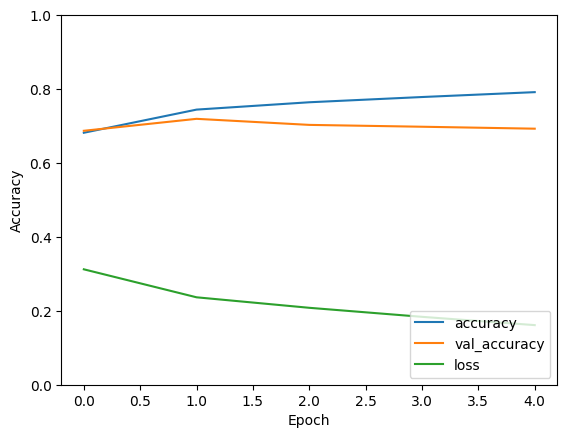

In [28]:
# train model
history = model_3.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_val, y_val))

# plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.plot(history.history['loss'], label = 'loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

In [75]:
# evaluate model

test_loss, test_acc, test_prec, test_rec, test_bin_acc = model.evaluate(X_test, y_test, verbose=2)

print('Test accuracy:', test_acc)
print('Test precision:', test_prec)
print('Test recall:', test_rec)
print('Test binary accuracy:', test_bin_acc)



923/923 - 2s - loss: 0.2925 - accuracy: 0.7205 - precision: 0.7969 - recall: 0.6966 - binary_accuracy: 0.8800 - 2s/epoch - 2ms/step
Test accuracy: 0.7204756140708923
Test precision: 0.7968881130218506
Test recall: 0.6965740323066711
Test binary accuracy: 0.8799582719802856


In [73]:
import wandb
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: 1hraaif (raaif). Use `wandb login --relogin` to force relogin


True

In [78]:
sweep_config = {
    'method': 'random',
    'metric': {
        'name': 'test_binary_accuracy',
        'goal': 'maximize'
    },
    'parameters': {
        'epochs': {
            'values': [10]
        },
        'batch_size': {
            'values': [64, 128]
        },
        'learning_rate': {
            'values': [0.01, 0.001, 0.0001]
        },
        'kernel_size': {
            'values': [3, 5, 7]
        },
        'filters': {
            'values': [16, 32, 64]
        },
        'layers': {
            'values': [2, 4, 6]
        },
        'hidden_units': {
            'values': [64, 128, 256]
        }
    }
}

In [79]:
def train():
    wandb.init()
    config = wandb.config
    
    num_classes = 5
    X_input = keras.Input(shape=X_train.shape[1:])
    outputs2, feature_output2 = resnet_model(X_input, num_classes=num_classes, filters=config.filters, kernels=config.kernel_size, layers=config.layers, hidden_units=config.hidden_units)

    model2 = keras.Model(inputs=X_input, outputs=outputs2)
    optimizer = keras.optimizers.Adam(learning_rate=0.01)
    model2.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall', metrics.binary_accuracy])
    model2.summary()
    
    model2.fit(X_train, y_train, epochs=config.epochs, batch_size=config.batch_size, validation_data=(X_val, y_val))
    
    # evaluate model
    test_loss, test_acc, test_prec, test_rec, test_bin_acc = model2.evaluate(X_test, y_test, verbose=2)
    wandb.log({'test_accuracy': test_acc, 'test_precision': test_prec, 'test_recall': test_rec, 'test_binary_accuracy': test_bin_acc})

In [80]:
sweep_id = wandb.sweep(sweep_config, project='ECG_Heartbeat_Classification')


Create sweep with ID: 4eud54zw
Sweep URL: https://wandb.ai/raaif/ECG_Heartbeat_Classification/sweeps/4eud54zw


In [81]:
wandb.agent(sweep_id, function=train)

wandb: Agent Starting Run: 5y1sab8u with config:
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	filters: 16
wandb: 	hidden_units: 128
wandb: 	kernel_size: 7
wandb: 	layers: 4
wandb: 	learning_rate: 0.0001
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 12)]    0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 194, 16)      1360        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 194, 16)     64          ['conv1d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 194, 16)      0           ['batch_normalization[0][0]']